In [18]:
# auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cns
import cns.data_utils as cdu

In [20]:
plt.rcParams.update({'font.size': 12})

In [21]:
cosmic_genes = cdu.load_COSMIC()
gene_start, gene_end = [(g_start, g_end) for g_start, g_end, g_name in cosmic_genes["chr3"] if g_name == "SOX2"][0]
arm_start = [band[2] for band in cns.hg19_cytobands if band[0] == "chr3" and band[4] == 'acen'][1]
arm_end = cns.hg19.chr_lens['chr3']

In [22]:
samples_df, cns_df = cdu.main_load("imp")
cns_df = cns.select_cns_by_type(cns_df, samples_df, "LUSC")

In [23]:
data_chr3 = cns_df.query("chrom == 'chr3'")
data_breaks_chrom = cns.segments_to_breaks(cns.cns_df_to_segments(data_chr3))["chr3"]
breaks_arm = [arm_start] + [breakpoint for breakpoint in data_breaks_chrom if arm_start < breakpoint < arm_end] + [arm_end]
len(breaks_arm)

4099

In [24]:
aggregated_data = cns.aggregate_by_breaks(data_chr3, {"chr3" : breaks_arm}, print_info=True)

Aggregated into 4081608 CNS.                                        


In [25]:
groups = cns.add_total_cn(cns.group_samples(aggregated_data))
groups["ampl"] = groups["total_cn"] - 2
groups["length"] = groups["end"] - groups["start"]
gene_cn = groups.query("@gene_start < end and @gene_end > start")["ampl"].min()

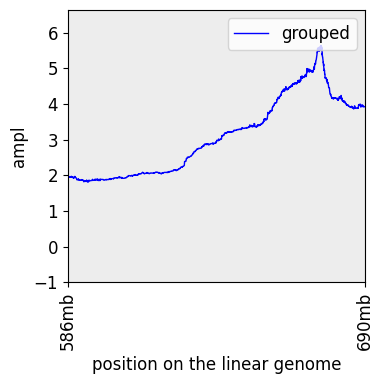

In [26]:
fig, axs = cns.fig_lines(groups.query("chrom == 'chr3'"), cn_columns="ampl")

In [27]:
# Initialize a list to store the ranges
random.seed(0)
ranges_inside = []
sim_segs = 1000

# Repeat until 8 ranges are sampled
while len(ranges_inside) < sim_segs:    
    rand_start = random.randint(arm_start, arm_end)
    rand_end = random.randint(arm_start, arm_end)
    if rand_start > rand_end:
        rand_start, rand_end = rand_end, rand_start

    if rand_start < gene_start and rand_end > gene_end:
        ranges_inside.append((rand_start, rand_end))

In [28]:
breaks = np.array(ranges_inside).flatten()
breaks.sort()
split_ranges = []

for r_start, r_end in ranges_inside:
    current_start = r_start

    for brk in breaks:
        if r_start < brk < r_end:
            split_ranges.append((current_start, brk))
            current_start = brk

    split_ranges.append((current_start, r_end))

In [29]:
# Count the occurrences of each pair
counts = pd.Series(split_ranges).value_counts().reset_index()

# Rename the columns
counts.columns = ['range', 'CN']

# Split the range into start and end
counts[['start', 'end']] = pd.DataFrame(counts['range'].tolist(), index=counts.index)

# Drop the 'range' column
counts = counts.drop('range', axis=1)

# Reorder the columns
counts = counts[['start', 'end', 'CN']].sort_values(by=['start'], ignore_index=True)
counts["total_cn"] = counts["CN"] / sim_segs * (gene_cn) + 2
counts["length"] = counts["end"] - counts["start"]
counts.head()

,start,end,CN,total_cn,length
0,93932305,93961279,1,2.005561,28974
1,93961279,94101791,2,2.011122,140512
2,94101791,94120286,3,2.016684,18495
3,94120286,94147384,4,2.022245,27098
4,94147384,94216426,5,2.027806,69042


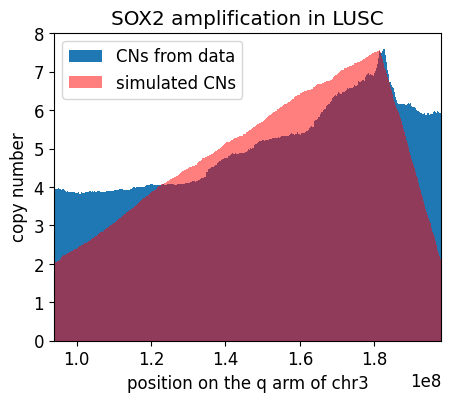

In [30]:
# bar plot groups 
fig, ax = plt.subplots(figsize=(5, 4))

# Create a bar plot
plt.bar(x=groups['start'], height=groups['total_cn'], width=groups["length"], align='edge')
plt.bar(x=counts['start'], height=counts['total_cn'], width=counts["length"], align='edge', alpha=0.5, color='red')


# Set the x-axis start to 0
plt.xlim(arm_start, max(counts['end']))

# label
plt.xlabel("position on the q arm of chr3")
plt.ylabel("copy number")
plt.title("SOX2 amplification in LUSC")

# add legend
plt.legend(["CNs from data", "simulated CNs"])

In [31]:
# Calculate the area of each bar plot
groups_area = np.sum(groups['total_cn'] * groups['length'])
counts_area = np.sum(counts['total_cn'] * counts['length'])

# Calculate the shared area using two-pointer technique
shared_area = 0
i, j = 0, 0

while i < len(groups) and j < len(counts):
    g_row = groups.iloc[i]
    c_row = counts.iloc[j]
    
    # Find the overlap between the two bars
    overlap_start = max(g_row['start'], c_row['start'])
    overlap_end = min(g_row['start'] + g_row['length'], c_row['start'] + c_row['length'])
    
    if overlap_start < overlap_end:
        overlap_length = overlap_end - overlap_start
        overlap_height = min(g_row['total_cn'], c_row['total_cn'])
        shared_area += overlap_length * overlap_height
    
    # Move the pointer that has the smaller end value
    if g_row['start'] + g_row['length'] < c_row['start'] + c_row['length']:
        i += 1
    else:
        j += 1

print(f"Area of groups: {groups_area}")
print(f"Area of counts: {counts_area}")
print(f"Shared area: {shared_area}")

Area of groups: 529584673.8403614
Area of counts: 509630256.2792841
Shared area: 477785347.2853748


In [32]:
overlap = shared_area / (groups_area + counts_area - shared_area)
print("Overalapping area:", overlap)

Overalapping area: 0.8510156249219468
